In [ ]:
!nvidia-smi

Sat Nov 23 04:52:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!rm -rf /content/Output
!rm -rf /content/Parkinson-Disease-Dataset

In [ ]:
!git clone "https://github.com/krupallad09/Parkinson-Disease-Dataset.git"

Cloning into 'Parkinson-Disease-Dataset'...
remote: Enumerating objects: 43099, done.
remote: Counting objects: 100% (9326/9326), done.
remote: Compressing objects: 100% (7826/7826), done.
remote: Total 43099 (delta 1053), reused 9325 (delta 1052), pack-reused 33773 (from 1)
Receiving objects: 100% (43099/43099), 3.34 GiB | 24.00 MiB/s, done.
Resolving deltas: 100% (3823/3823), done.
Updating files: 100% (40162/40162), done.


In [ ]:
no_of_image_PD = 450
no_of_image_HC = 'ALL'

In [ ]:
!apt-get install dcm2niix
!pip install nibabel pydicom
!pip install nibabel scikit-image matplotlib
!pip install PyWavelets
!pip install thop

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libyaml-cpp0.7 pigz
The following NEW packages will be installed:
  dcm2niix libyaml-cpp0.7 pigz
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 417 kB of archives.
After this operation, 1,393 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 pigz amd64 2.6-1 [63.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libyaml-cpp0.7 amd64 0.7.0+dfsg-8build1 [97.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dcm2niix amd64 1.0.20211006-1build1 [256 kB]
Fetched 417 kB in 1s (654 kB/s)
Selecting previously unselected package pigz.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.6-1_amd64.deb ...
Unpacking pigz (2.6-1) ...
Selecting previously unselected package libyaml-cpp

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from scipy.ndimage import zoom

In [ ]:
def get_dirs(dir):
  image_list = []
  for(root, dirs, file) in os.walk(dir):
    for d1 in dirs:
      image_list.append(os.path.join(root, d1))
  return image_list

def convert_image(input, output):
  output_path = os.path.join(output)
  os.makedirs(output_path, exist_ok=True)
  # Run dcm2niix to convert DICOM to NIfTI
  !dcm2niix -o {output_path} {input}


def convert_to_nii_images(input_folder, output_folder, target = "ALL"):
  count = 0
  for dirs in get_dirs(input_folder):
    for d1 in get_dirs(dirs):
      for d2 in get_dirs(d1):
        for d3 in get_dirs(d2):
          if target != "ALL" and count >= target:
            break
          convert_image(d3, output_folder)
          count += 1
    if target != "ALL" and count >= target:
      break

In [ ]:
PD_folder = "/content/Parkinson-Disease-Dataset/PD_2D/PD"
PD_Output_folder = "/content/Output/Parkinson-Disease-Dataset/PD_2D/PD"
HC_folder = "/content/Parkinson-Disease-Dataset/PD_2D/HC"
HC_Output_folder = "/content/Output/Parkinson-Disease-Dataset/PD_2D/HC"

convert_to_nii_images(PD_folder, PD_Output_folder, no_of_image_PD)
convert_to_nii_images(HC_folder, HC_Output_folder, no_of_image_HC)

Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 50 DICOM file(s)
Convert 50 DICOM as /content/Output/Parkinson-Disease-Dataset/PD_2D/PD/I814625_Axial_PD-T2_TSE_20160211143453_6_e2 (228x256x50x1)
Conversion required 0.058245 seconds (0.046500 for core code).
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 48 DICOM file(s)
Convert 48 DICOM as /content/Output/Parkinson-Disease-Dataset/PD_2D/PD/I893125_Axial_PD-T2_TSE_20170626160617_1_e2 (228x256x48x1)
Conversion required 0.103730 seconds (0.047096 for core code).
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 48 DICOM file(s)
Convert 48 DICOM as /content/Output/Parkinson-Disease-Dataset/PD_2D/PD/I440163_Axial_PD-T2-FS_TSE_20140812112302_9_e2 (204x256x48x1)
Conversion required 0.214830 seconds (0.051709 for core code).
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11

In [ ]:
def load_image(img_path):
    # Use memory mapping to reduce RAM consumption
    img_data = nib.load(img_path, mmap=True)
    # # Squeeze if necessary
    # if img_data.shape[-1] == 1:
    #   img_data = np.squeeze(img_data, axis=-1)
    return img_data.get_fdata()

def load_image_and_resize(img_path, target_shape=(128, 128, 32)):
    img_data = load_image(img_path)
    # removing image with > 3 shape or < 10 slides
    # print(img_data.shape)
    if (len(img_data.shape) > 3 or img_data.shape[-1] < 10):
      return None
    # Resize the image to target shape
    zoom_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, img_data.shape)]
    img_data_resized = zoom(img_data, zoom_factors, order=3)

    return img_data_resized

def load_nii_images(img_folder_path, target_shape=None, transform=None):
    images = []

    # Iterate through files using os.scandir for better performance
    with os.scandir(img_folder_path) as entries:
      for entry in entries:
        if entry.is_file() and entry.name.endswith('.nii'):
          if target_shape is not None:
            img = load_image_and_resize(entry.path, target_shape)
          else:
            img = load_image(entry.path)

          if img is None:
            continue

          if transform is not None:
            img = transform(img)

          # Check if img is a NumPy array and convert it to PyTorch tensor
          if isinstance(img, np.ndarray):
            img_data_tensor = torch.from_numpy(img).float()
          else:
            img_data_tensor = img.float()

          # img_data_tensor = img_data_tensor.permute(2, 0, 1)  # Change the order to (no of slides, height, width)
          images.append(img_data_tensor)

    # images = [img_data_tensor.cpu().numpy() if img_data_tensor.is_cuda else img_data_tensor.numpy() for img_data_tensor in images]

    return images

In [ ]:
PD_NII_folder = "/content/Output/Parkinson-Disease-Dataset/PD_2D/PD"
HC_NII_folder = "/content/Output/Parkinson-Disease-Dataset/PD_2D/HC"

# Transformations: normalize and convert to Tensor
normalize_transform = transforms.Normalize([0.5] * 32, [0.5] * 32)

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts numpy array to tensor
    normalize_transform  # Normalize assuming MRI data in [0, 1] range with 32 slides
])

# Load images without resizing and transforming
# PD_nifti_images = load_nii_images(PD_NII_folder)
# HC_nifti_images = load_nii_images(HC_NII_folder)
PD_nifti_images = load_nii_images(PD_NII_folder, (128, 128, 32), transform)
HC_nifti_images = load_nii_images(HC_NII_folder, (128, 128, 32), transform)

In [ ]:
print(len(PD_nifti_images), len(HC_nifti_images))
print(PD_nifti_images[0].shape)
# print(PD_nifti_images[0])
print(HC_nifti_images[0].shape)
# print(HC_nifti_images[0])

451 213
torch.Size([32, 128, 128])
torch.Size([32, 128, 128])


In [ ]:
all_images = PD_nifti_images + HC_nifti_images
label = [0] * len(PD_nifti_images) + [1] * len(HC_nifti_images)

# all_images = all_images.permute(1, 2, 0)
# do it for each image
# all_image_temp = []
# for image in all_images:
#   all_image_temp.append(image.permute(1, 2, 0))
# all_images = all_image_temp

print(all_images[0].shape)

torch.Size([32, 128, 128])


torch.Size([32, 128, 128]) (32, 128, 128)


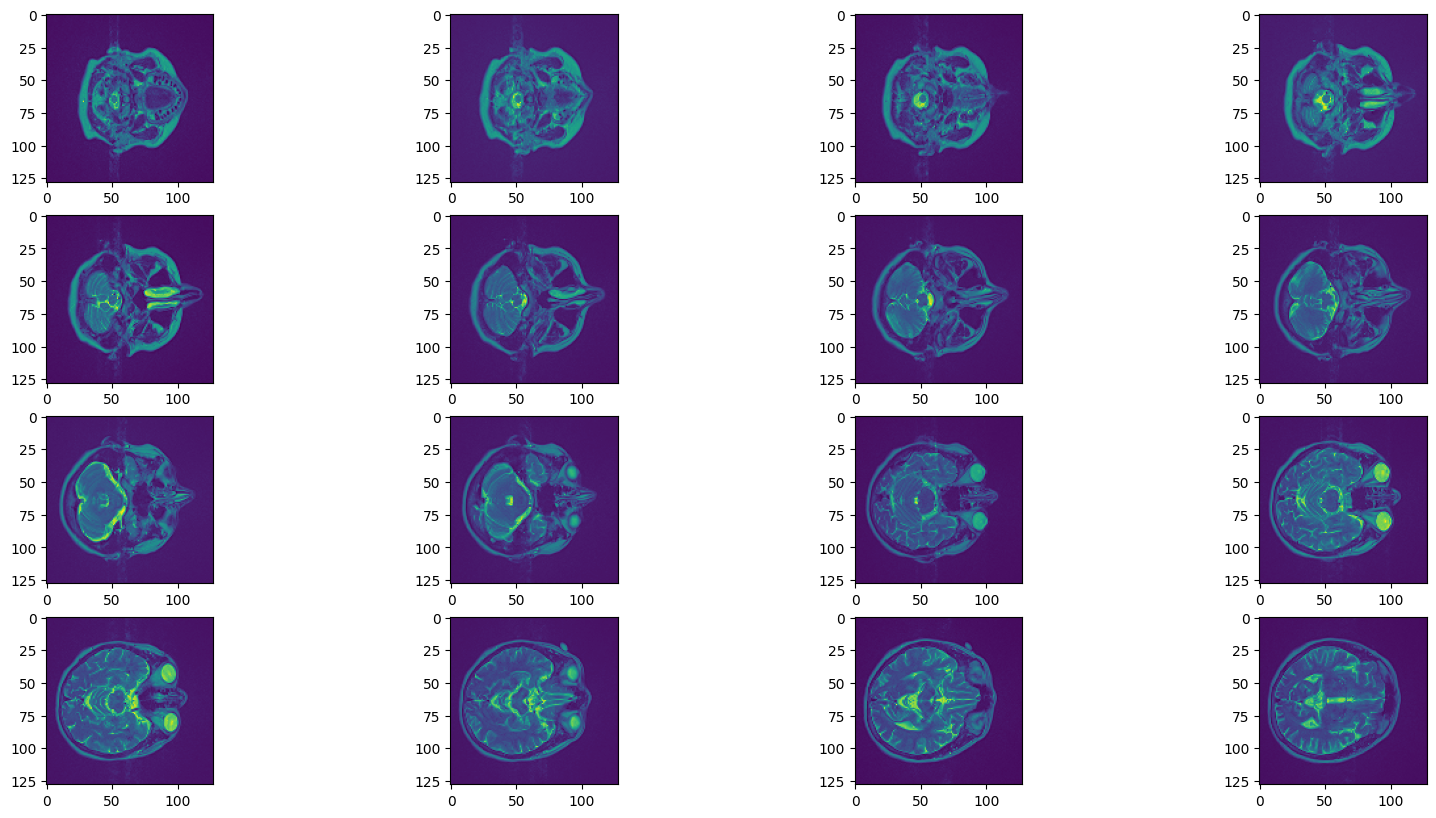

In [ ]:
head_mri = all_images[0]
# print(head_mri)
print(head_mri.shape, head_mri.numpy().shape)

fig, axis = plt.subplots(4, 4, figsize=(20, 10))
slice_counter = 0
for i in range(4):
    for j in range(4):
      numpy_arr = head_mri.numpy()
      axis[i][j].imshow(numpy_arr[slice_counter,:,:])
      slice_counter+=1

In [ ]:
import math
import torchvision.transforms as transforms
import tensorflow as tf
import torch.nn.functional as F

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
image_train_val, image_test, label_train_val, label_test = train_test_split(all_images, label, test_size=0.10, random_state=42)

image_train, image_val, label_train, label_val = train_test_split(image_train_val, label_train_val, test_size=0.25, random_state=42)

print(f"Train size: {len(image_train)}, Validation size: {len(image_val)}, Test size: {len(image_test)}")

Train size: 447, Validation size: 150, Test size: 67


In [ ]:
image_train_tensor = torch.stack(image_train)  # Stack the list of tensors into a single tensor
image_val_tensor = torch.stack(image_val)  # Stack the list of tensors into a single tensor

In [ ]:
train_labels_tensor = torch.tensor(label_train, dtype=torch.long)
val_labels_tensor = torch.tensor(label_val, dtype=torch.long)

In [ ]:
image_test_tensor = torch.stack(image_test)
labels_test_tensor = torch.tensor(label_test, dtype=torch.long)

In [ ]:
test_dataset = TensorDataset(image_test_tensor, labels_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(image_train), image_train[0].shape)

447 torch.Size([32, 128, 128])


In [ ]:
print(image_train_tensor.shape, train_labels_tensor.shape)

batch_size = 8

train_dataset = TensorDataset(image_train_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(image_val_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([447, 32, 128, 128]) torch.Size([447])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size = 5,
        spline_order = 3,
        scale_noise = 0.1,
        scale_base = 1.0,
        scale_spline = 1.0,
        enable_standalone_scale_spline = True,
        base_activation = torch.nn.SiLU,
        grid_eps = 0.02,
        grid_range = [-1, 1],
        use_linear = True,
        use_layernorm = False
    ):
        # super(KANLinear, self).__init__()
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.use_linear = use_linear
        self.use_layernorm = use_layernorm

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        if self.use_linear:
            self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()
        if self.use_layernorm:
            self.layernorm = torch.nn.LayerNorm(in_features)

    def reset_parameters(self):
        if self.use_linear:
            torch.nn.init.kaiming_uniform_(self.base_weight, a = math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        if self.use_layernorm:
            x = self.layernorm(x)

        if self.use_linear:
            base_output = F.linear(self.base_activation(x), self.base_weight)
        else:
            base_output = 0

        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output if self.use_linear else spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin = 0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim = 0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype = torch.int64, device = x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype = torch.float32, device = x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device = x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device = x.device).unsqueeze(1),
            ],
            dim = 0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation = 1.0, regularize_entropy = 1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size = 5,
        spline_order = 3,
        scale_noise = 0.1,
        scale_base = 1.0,
        scale_spline = 1.0,
        base_activation = torch.nn.SiLU,
        grid_eps = 0.02,
        grid_range = [-1, 1],
    ):
        # super(KAN, self).__init__()
        super().__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size = grid_size,
                    spline_order = spline_order,
                    scale_noise = scale_noise,
                    scale_base = scale_base,
                    scale_spline = scale_spline,
                    base_activation = base_activation,
                    grid_eps = grid_eps,
                    grid_range = grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid = False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation = 1.0, regularize_entropy = 1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [ ]:
# Credits to: https://github.com/detkov/Convolution-From-Scratch/
# Adapted to a more vectorized operation
import torch
from typing import List, Tuple, Union


def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size,n_channels,n, m = matrix.shape
    h_out = np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    b = [kernel_side // 2, kernel_side// 2]
    return h_out,w_out,batch_size,n_channels

def kan_conv2d(matrix: torch.Tensor, kernel: torch.nn.Module, kernel_side: int,
               stride: Tuple[int, int] = (1, 1), dilation: Tuple[int, int] = (1, 1), padding: Tuple[int, int] = (0, 0),
               device: str = "cuda") -> torch.Tensor:
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)

    matrix_out = torch.zeros((batch_size, n_channels, h_out, w_out), device=matrix.device)
    unfold = torch.nn.Unfold(kernel_size = (kernel_side, kernel_side), dilation = dilation, padding = padding, stride = stride)

    unfolded_matrix = unfold(matrix)
    unfolded_matrix = unfolded_matrix.view(batch_size, n_channels, kernel_side * kernel_side, h_out * w_out)
    conv_groups = unfolded_matrix.permute(0, 1, 3, 2)

    conv_result = kernel(conv_groups.reshape(-1, kernel_side * kernel_side))
    matrix_out = conv_result.view(batch_size, n_channels, h_out, w_out)

    return matrix_out

def multiple_convs_kan_conv2d(matrix: torch.Tensor, kernels: List[torch.nn.Module], kernel_side: int,
                              stride: Tuple[int, int] = (1, 1), dilation: Tuple[int, int] = (1, 1),
                              padding: Tuple[int, int] = (0, 0), device: str = "cuda") -> torch.Tensor:
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)

    unfold = torch.nn.Unfold(kernel_size = (kernel_side, kernel_side), dilation = dilation, padding = padding, stride = stride)

    unfolded_matrix = unfold(matrix)
    unfolded_matrix = unfolded_matrix.view(batch_size, n_channels, kernel_side * kernel_side, h_out * w_out)
    conv_groups = unfolded_matrix.permute(0, 1, 3, 2)

    results = []
    for kernel in kernels:
        conv_result = kernel.conv.forward(conv_groups.reshape(-1, kernel_side * kernel_side))
        results.append(conv_result.view(batch_size, n_channels, h_out, w_out))

    matrix_out = torch.cat(results, dim = 1)

    return matrix_out

def add_padding(matrix: np.ndarray,
                padding: Tuple[int, int]) -> np.ndarray:
    n, m = matrix.shape
    r, c = padding

    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix

    return padded_matrix

In [ ]:
# Credits to: https://github.com/AntonioTepsich/Convolutional-KANs

# from KAN_Conv.KANLinear import KANLinear
# from KAN_Conv.fastkan import FastKANLayer
# from KAN_Conv.chebyshevkan import ChebyshevKANLinear
# from KAN_Conv.convolution import *
# import KAN_Conv.convolution as convolution

class KAN_Convolutional_Layer(torch.nn.Module):
    def __init__(
            self,
            n_convs: int = 1,
            kernel_size: tuple = (3,3),
            stride: tuple = (1,1),
            padding: tuple = (1,1),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order:int = 3,
            scale_noise:float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation = torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = (-1, 1),
            chebyshev_degree: int = 3,
            kan_type: str = "b_spline",
            use_linear: bool = True,
            device: str = "cpu"
        ):
        """
        Kan Convolutional Layer with multiple convolutions

        Args:
            n_convs (int): Number of convolutions to apply
            kernel_size (tuple): Size of the kernel
            stride (tuple): Stride of the convolution
            padding (tuple): Padding of the convolution
            dilation (tuple): Dilation of the convolution
            grid_size (int): Size of the grid
            spline_order (int): Order of the spline
            scale_noise (float): Scale of the noise
            scale_base (float): Scale of the base
            scale_spline (float): Scale of the spline
            base_activation (torch.nn.Module): Activation function
            grid_eps (float): Epsilon of the grid
            grid_range (tuple): Range of the grid
            device (str): Device to use
        """


        # super(KAN_Convolutional_Layer, self).__init__()
        super().__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        self.device = device
        self.dilation = dilation
        self.padding = padding
        self.convs = torch.nn.ModuleList()
        self.n_convs = n_convs
        self.stride = stride
        self.chebyshev_degree = chebyshev_degree
        self.kan_type = kan_type
        self.use_linear = use_linear

        # Create n_convs KAN_Convolution objects
        for _ in range(n_convs):
            self.convs.append(
                KAN_Convolution(
                    kernel_size = kernel_size,
                    stride = stride,
                    padding = padding,
                    dilation = dilation,
                    grid_size = grid_size,
                    spline_order = spline_order,
                    scale_noise = scale_noise,
                    scale_base = scale_base,
                    scale_spline = scale_spline,
                    base_activation = base_activation,
                    grid_eps = grid_eps,
                    grid_range = grid_range,
                    chebyshev_degree = chebyshev_degree,
                    kan_type = kan_type,
                    use_linear = self.use_linear,
                    device = device
                )
            )

    def forward(self, x: torch.Tensor, update_grid = False):
        # If there are multiple convolutions, apply them all
        if self.n_convs>1:
            return multiple_convs_kan_conv2d(x, list(self.convs), self.kernel_size[0], self.stride,self.dilation, self.padding,self.device)

        # If there is only one convolution, apply it
        return self.convs[0].forward(x)


class KAN_Convolution(torch.nn.Module):
    def __init__(
            self,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order: int = 3,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = (-1, 1),
            chebyshev_degree: int = 3,
            kan_type: str = "b_spline",
            use_linear: bool = True,
            device = "cpu"
        ):
        """
        Args
        """
        # super(KAN_Convolution, self).__init__()
        super().__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.device = device

        # if kan_type == "rbf":
        #     self.conv = FastKANLayer(
        #         input_dim = math.prod(kernel_size),
        #         output_dim = 1,
        #         grid_min = -2,
        #         grid_max = 2,
        #         num_grids = grid_size,
        #         use_base_update = use_linear,
        #         base_activation = base_activation,
        #         use_layernorm = True,
        #         spline_weight_init_scale = scale_spline,
        #     )

        # elif kan_type == "chebyshev":
        #     self.conv = ChebyshevKANLinear(
        #         in_features = math.prod(kernel_size),
        #         out_features = 1,
        #         chebyshev_degree = chebyshev_degree,
        #         base_activation = base_activation,
        #         use_linear = use_linear,
        #         normalization = "tanh",
        #         use_layernorm = False,
        #         clip_min = -5.0,
        #         clip_max = 5.0,
        #         use_clip = False,
        #         eps = 1e-8
        #     )

        # elif kan_type == "b_spline":
        self.conv = KANLinear(
            in_features = math.prod(kernel_size),
            out_features = 1,
            grid_size = grid_size,
            spline_order = spline_order,
            scale_noise = scale_noise,
            scale_base = scale_base,
            scale_spline = scale_spline,
            base_activation = base_activation,
            grid_eps = grid_eps,
            grid_range = grid_range,
            use_linear = use_linear,
            use_layernorm = False
        )

        # else:
        #     raise ValueError(f"Unsupported kan_type: {kan_type}. Choose from 'rbf', 'chebyshev', 'b_spline'.")

    def forward(self, x: torch.Tensor, update_grid = False):
        return kan_conv2d(x, self.conv, self.kernel_size[0], self.stride, self.dilation,self.padding, self.device)

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch
# from KAN_Conv.KANConv import KAN_Convolutional_Layer
# from KAN_Conv.KANLinear import KANLinear

class RKAN_ResNet(nn.Module):
    def __init__(self, num_classes = 2, version = "resnet34", kan_type = "chebyshev", pretrained = False, main_conv = "resnet",
                 fcl = "resnet", log_norms = False, reduce_factor = [4, 4, 4, 4], grid_size = 5, n_convs = 1, dataset_size = "small",
                 single_conv = True, mechanisms = [None, None, None, None], scaling = False, freeze_weights = False):
        super(RKAN_ResNet, self).__init__()

        self.used_parameters = set()
        self.printed_params = False
        self.single_conv = single_conv
        self.mechanisms = mechanisms
        self.fcl = fcl
        self.main_conv = main_conv
        self.log_norms = log_norms
        self.scaling = scaling

        if self.scaling:
            self.scaling_factor = nn.Parameter(torch.ones(1))

        if pretrained:
            self.resnet = getattr(models, version)(weights = "DEFAULT")
            if freeze_weights:
                for name, param in self.resnet.named_parameters():
                    if "fc" in name:
                        param.requires_grad = True
                    else:
                        param.requires_grad = False
        else:
            self.resnet = getattr(models, version)(weights = None)

        if log_norms:
            self.base_norms = []
            self.residual_norms = []
            self.combined_norms = []

        if len(self.mechanisms) != 4:
            raise ValueError(f"Length of mechanisms ({len(self.mechanisms)}) must match the number of stages (4).")

        if dataset_size == "small":
            self.kan_conv_main = KAN_Convolutional_Layer(n_convs = 1, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), grid_size = grid_size)
            self.resnet.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
            self.resnet.maxpool = nn.Identity()
        elif dataset_size == "medium":
            self.kan_conv_main = KAN_Convolutional_Layer(n_convs = 1, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), grid_size = grid_size)
            self.resnet.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
            self.resnet.maxpool = nn.Identity()
        elif dataset_size == "large":
            self.kan_conv_main = KAN_Convolutional_Layer(n_convs = 1, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), grid_size = grid_size)
        else:
            raise ValueError(f"Invalid value for dataset_size: {dataset_size}. Choose 'small', 'medium', or 'large'.")

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        layer_config = {
            "resnet18": [64, 128, 256, 512],
            "resnet34": [64, 128, 256, 512],
            "resnet50": [256, 512, 1024, 2048],
            "resnet101": [256, 512, 1024, 2048],
            "resnet152": [256, 512, 1024, 2048]
        }
        channels = layer_config[version]

        # KAN convolutions for each layer
        self.kan_conv1 = nn.ModuleList([
            KAN_Convolutional_Layer(n_convs = n_convs, kernel_size = (3, 3), stride = (1, 1) if i == 0 else (2, 2),
                                    padding = (1, 1), grid_size = grid_size, kan_type = kan_type)
            for i in range(4)
        ])

        self.kan_conv2 = nn.ModuleList([
            KAN_Convolutional_Layer(n_convs = n_convs, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), grid_size = grid_size, kan_type = kan_type)
            for _ in range(4)
        ])

        # Optional KAN layers
        self.conv_expand_main = nn.Conv2d(3, 64, kernel_size = 1, stride = 1, bias = False)
        self.kan_linear = KANLinear(in_features = self.resnet.fc.in_features, out_features = num_classes, grid_size = grid_size)

        ## Bottleneck for KAN
        self.conv_reduce = nn.ModuleList([
            nn.Conv2d(64, 64 // reduce_factor[0], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d(channels[0], channels[0] // reduce_factor[1], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d(channels[1], channels[1] // reduce_factor[2], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d(channels[2], channels[2] // reduce_factor[3], kernel_size = 1, stride = 1, bias = False)
        ])

        self.conv_expand = nn.ModuleList([
            nn.Conv2d((64 // reduce_factor[0]) * n_convs, channels[0], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d((channels[0] // reduce_factor[1]) * n_convs, channels[1], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d((channels[1] // reduce_factor[2]) * n_convs, channels[2], kernel_size = 1, stride = 1, bias = False),
            nn.Conv2d((channels[2] // reduce_factor[3]) * n_convs, channels[3], kernel_size = 1, stride = 1, bias = False)
        ])

        ## KAN normalization
        self.kan_bn1 = nn.ModuleList([nn.BatchNorm2d(ch // reduce_factor[i]) for i, ch in enumerate([64] + channels[:-1])])
        self.kan_bn2 = nn.ModuleList([nn.BatchNorm2d(ch // reduce_factor[i]) for i, ch in enumerate([64] + channels[:-1])])
        self.kan_expand_bn = nn.ModuleList([nn.BatchNorm2d(ch) for ch in channels])
        self.kan_reduce_bn = nn.ModuleList([nn.BatchNorm2d(ch // reduce_factor[i]) for i, ch in enumerate([64] + channels[:-1])])

        # Residual mechanisms
        self.gate_convs = nn.ModuleList([nn.Conv2d(ch, ch, kernel_size = 1) for ch in channels])
        self.gamma_convs = nn.ModuleList([nn.Conv2d(ch, ch, kernel_size = 1) for ch in channels])
        self.beta_convs = nn.ModuleList([nn.Conv2d(ch, ch, kernel_size = 1) for ch in channels])
        self.attention_convs = nn.ModuleList([nn.Conv2d(ch * 2, 2, kernel_size = 1) for ch in channels])
        self.glu_conv_upscale = nn.ModuleList([nn.Conv2d(ch // 2, ch, kernel_size = 1) for ch in channels])
        self.se_blocks = nn.ModuleList([self._make_se_block(ch, reduction = 16) for ch in channels])
        self.cbam_channel = nn.ModuleList([self._make_cbam_channel_block(ch, reduction = 16) for ch in channels])

        self.cbam_spatial = nn.ModuleList([
            nn.Conv2d(2, 1, kernel_size = 7, padding = 3),
            nn.Conv2d(2, 1, kernel_size = 7, padding = 3),
            nn.Conv2d(2, 1, kernel_size = 5, padding = 2),
            nn.Conv2d(2, 1, kernel_size = 3, padding = 1)
        ])

    def _make_se_block(self, channels, reduction = 16):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
    )

    def _make_cbam_channel_block(self, channels, reduction = 16):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1)
        )

    def apply_mechanism(self, out, residual, layer_index, mechanism):
        if self.scaling:
            residual = residual * self.scaling_factor

        if mechanism == "mult_sigmoid":
            return out * (1 + torch.sigmoid(residual))

        elif mechanism == "tanh":
            return out + torch.tanh(residual) * out

        elif mechanism == "sigmoid":
            return out + torch.sigmoid(residual) * out

        elif mechanism == "relu":
            return out + torch.relu(residual)

        elif mechanism == "exp":
            return out * torch.exp(torch.tanh(residual))

        elif mechanism == "sig_tanh":
            return out + torch.sigmoid(residual) * torch.tanh(residual) * out

        elif mechanism == "addition":
            return out + residual

        elif mechanism == "gating":
            gate = torch.sigmoid(self.gate_convs[layer_index](residual))
            return out * gate + residual * (1 - gate)

        elif mechanism == "se":
            se_weight = self.se_blocks[layer_index](residual)
            self._add_params([self.se_blocks[layer_index]])
            return out * se_weight + residual

        elif mechanism == "film":
            gamma = self.gamma_convs[layer_index](residual)
            beta = self.beta_convs[layer_index](residual)
            self._add_params([self.gamma_convs[layer_index], self.beta_convs[layer_index]])
            return out * (1 + gamma) + beta

        elif mechanism == "attention":
            combined = torch.cat([out, residual], dim = 1)
            attention = torch.softmax(self.attention_convs[layer_index](combined), dim = 1)
            self._add_params([self.attention_convs[layer_index]])
            return out * attention[:, 0:1] + residual * attention[:, 1:2]

        elif mechanism == "glu":
            channels = residual.size(1)
            gate = torch.sigmoid(residual[:, :channels // 2])
            gated_residual = residual[:, channels // 2:] * gate
            gated_residual = self.glu_conv_upscale[layer_index](gated_residual)
            self._add_params([self.glu_conv_upscale[layer_index]])
            return out + gated_residual

        elif mechanism == "cbam":
            avg_pool = torch.mean(residual, dim = (2, 3), keepdim = True)
            max_pool = torch.max(residual, dim = 2, keepdim = True)[0].max(dim = 3, keepdim = True)[0]
            channel_attention = torch.sigmoid(self.cbam_channel[layer_index](avg_pool) + self.cbam_channel[layer_index](max_pool))
            residual = residual * channel_attention
            avg_pool = torch.mean(residual, dim = 1, keepdim = True)
            max_pool = torch.max(residual, dim = 1, keepdim = True)[0]
            spatial_attention = torch.sigmoid(self.cbam_spatial[layer_index](torch.cat([avg_pool, max_pool], dim = 1)))
            self._add_params([self.cbam_channel[layer_index], self.cbam_spatial[layer_index]])
            return out + residual * spatial_attention

        else:
            raise ValueError(f"Invalid mechanism: {mechanism}.")

    def _add_params(self, modules):
        for module in modules:
            for param in module.parameters():
                if param.requires_grad:
                    self.used_parameters.add(param)

    def reset_norms(self):
        self.base_norms = []
        self.residual_norms = []
        self.combined_norms = []

    def forward(self, x):
        if self.main_conv == "resnet":
            out = self.resnet.conv1(x)
            out = self.resnet.bn1(out)
            out = self.resnet.relu(out)
            out = self.resnet.maxpool(out)
            self._add_params([self.resnet.conv1, self.resnet.bn1])
        elif self.main_conv == "kan":
            out = self.conv_expand_main(self.kan_conv_main(x))
            out = self.resnet.bn1(out)
            out = self.resnet.maxpool(out)
            self._add_params([self.kan_conv_main, self.conv_expand_main, self.resnet.bn1])
        else:
            raise ValueError(f"Invalid value for main_conv: {self.main_conv}. Choose 'resnet' or 'kan'.")

        layers = [self.resnet.layer1, self.resnet.layer2, self.resnet.layer3, self.resnet.layer4]
        for i, (layer, mechanism) in enumerate(zip(layers, self.mechanisms)):
            identity = out
            out = layer(out)
            self._add_params([layer])

            if mechanism is not None:
                residual = self.conv_reduce[i](identity)
                if not self.single_conv:
                    residual = self.kan_conv1[i](residual)
                    residual = self.kan_conv2[i](residual)
                    self._add_params([self.kan_conv1[i], self.kan_conv2[i]])
                else:
                    residual = self.kan_conv1[i](residual)
                    self._add_params([self.kan_conv1[i]])
                residual = self.conv_expand[i](residual)
                residual = self.kan_expand_bn[i](residual)
                if self.log_norms:
                    self.base_norms.append(torch.norm(out).item())
                    self.residual_norms.append(torch.norm(residual).item())
                out = self.apply_mechanism(out, residual, i, mechanism)
                if self.log_norms:
                    self.combined_norms.append(torch.norm(out).item())
                self._add_params([self.conv_reduce[i], self.conv_expand[i], self.kan_expand_bn[i]])

        out = self.resnet.avgpool(out)
        out = torch.flatten(out, 1)
        if self.fcl == "resnet":
            out = self.resnet.fc(out)
            self._add_params([self.resnet.fc])
        elif self.fcl == "kan":
            out = self.kan_linear(out)
            self._add_params([self.kan_linear])
        else:
            raise ValueError(f"Invalid value for fcl: {self.fcl}. Choose 'resnet' or 'kan'.")

        if not self.printed_params:
            total_params = sum(p.numel() for p in self.used_parameters)
            print(f"Total Parameters: {total_params / 1e6:.4f}M")
            self.printed_params = True
        return out

In [ ]:
model_configs = {
    "resnet34": {"class": RKAN_ResNet, "reduce_factor": lambda r: r, "single_conv": True},
}

In [ ]:
from thop import profile
from contextlib import redirect_stdout
import io
import math
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience = 100, min_delta = 0, monitor = "loss", path = "best.pt", save_model = True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path
        self.monitor = monitor
        self.save_model = save_model

    def __call__(self, value, model):
        if self.monitor == "loss":
            score = -value
        elif self.monitor == "accuracy":
            score = value
        else:
            raise ValueError(f"Invalid monitor value '{self.monitor}'.")

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        if self.save_model:
            torch.save(model, self.path)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), "valid") / window_size

def warmup_scheduler(epoch, warmup_epochs):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

def profile_model(model, input_size, device):
    model.eval()
    input_tensor = torch.randn(1, 32, input_size, input_size).to(device)
    captured_output = io.StringIO()
    with redirect_stdout(captured_output):
        with torch.no_grad():
            flops, params, *_ = profile(model, inputs=(input_tensor,))
    print(f"FLOPs: {flops / 1e9:.4f} GFLOPs")
    print(f"Parameters: {params / 1e6:.4f}M")

def cutmix_data(x, y, alpha = 1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(2) * x.size(3)))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    H = size[2]
    W = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha = 0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR, OneCycleLR, ExponentialLR, CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import time

In [ ]:
model_name = "resnet34"
train_status = "full"
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_size = "medium" # len(image_train) # ??? need to check
input_size = 32 # ??? need to check

torch.cuda.empty_cache()


reduce_factor = [1, 1, 1, 1]
mechanisms = [None, None, "addition", "addition"]
pretrained = True if train_status == "transfer" else False
model_config = model_configs.get(model_name)
if model_config is None:
    raise ValueError(f"Unknown model name: '{model_name}'.")
model = model_config["class"](version = model_name, num_classes = num_classes, reduce_factor = model_config["reduce_factor"](reduce_factor), scaling = False,
                              dataset_size = dataset_size, pretrained = pretrained, mechanisms = mechanisms, single_conv = model_config["single_conv"]).to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# model.half()

In [ ]:
warmup_epochs = 0
use_cutmix = use_mixup = True
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)

if train_status == "full":
    initial_lr = 0.1
    num_epochs = 200
    optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum = 0.9, weight_decay = 5e-5)
    # scheduler = ReduceLROnPlateau(optimizer, "min", patience = 5, factor = 0.5)
    # scheduler = ExponentialLR(optimizer, gamma = 0.95)
    scheduler = OneCycleLR(optimizer, max_lr = 0.1, steps_per_epoch = len(train_loader), epochs = num_epochs, pct_start = 0.2, div_factor = 10, final_div_factor = 200)

elif train_status == "transfer":
    use_cutmix = False
    initial_lr = 0.001
    num_epochs = 50

    if hasattr(model, "freeze_weights") and model.freeze_weights:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = initial_lr, weight_decay = 1e-4)
    else:
        optimizer = optim.AdamW(model.parameters(), lr = initial_lr, weight_decay = 1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min = 1e-5)
else:
    raise ValueError(f"Unknown train_status: '{train_status}'.")

# Define a lambda function separately
def warmup_lr(epoch, warmup_epochs):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs  # Linear warm-up
    return 1  # After warm-up, keep learning rate multiplier as 1

# Use the defined function in LambdaLR
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_lr(epoch, warmup_epochs))

# warmup_scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: warmup_scheduler(epoch, warmup_epochs))
scaler = GradScaler()
early_stopping = EarlyStopping(patience = num_epochs, min_delta = 0, monitor = "accuracy", path = "best.pt")

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_accuracy, best_epoch = 0.0, -1
if hasattr(model, "log_norms") and model.log_norms:
    train_base_norms, train_residual_norms, train_combined_norms = [], [], []

def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    top5_correct = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # print(inputs.shape)
        optimizer.zero_grad()
        rand = np.random.rand()
        if use_cutmix and rand < 0.35:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        elif use_mixup and rand < 0.7:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha = 0.2)
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            targets_a = targets

        scaler.scale(loss).backward()
        scale_before = scaler.get_scale()
        scaler.step(optimizer)
        scaler.update()
        if scale_before <= scaler.get_scale() and isinstance(scheduler, OneCycleLR):
            scheduler.step()

        if hasattr(model, "log_norms") and model.log_norms:
            train_base_norms.extend(model.base_norms)
            train_residual_norms.extend(model.residual_norms)
            train_combined_norms.extend(model.combined_norms)
            model.reset_norms()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets_a).sum().item()
        topk = min(5, outputs.size(1))  # Avoid top-5 if batch size is smaller than 5
        top5_correct += torch.topk(outputs, topk, dim=1)[1].eq(targets_a.view(-1, 1)).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    print(f"Epoch [{epoch + 1}/{num_epochs}]\n"
          f"Training Loss: {running_loss / len(train_loader):.4f}, "
          f"Top-1 Accuracy: {100. * correct/total:.2f}%, "
          f"Top-{topk} Accuracy: {100. * top5_correct/total:.2f}%, "
          f"Learning Rate: {optimizer.param_groups[0]['lr']}")

def validate():
    global best_accuracy, best_epoch
    model.eval()
    running_loss = 0.0
    correct = top5_correct = total = 0
    all_targets, all_preds = [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            topk = min(5, outputs.size(1))  # Avoid top-5 if batch size is smaller than 5
            top5_correct += torch.topk(outputs, topk, dim=1)[1].eq(targets.view(-1, 1)).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    f1 = f1_score(all_targets, all_preds, average = "macro")
    val_loss = running_loss / len(val_loader)
    val_losses.append(running_loss / len(val_loader))
    val_accuracy = 100. * correct / total
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

    elapsed_time = time.time() - start_time
    print(f"Validation Loss: {val_loss:.4f}, "
          f"Top-1 Accuracy: {val_accuracy:.2f}%, "
          f"Top-{topk} Accuracy: {100. * top5_correct/total:.2f}%\n"
          f"Best Accuracy: {best_accuracy:.2f}% (Epoch {best_epoch}), F1 Score: {f1:.4f}, "
          f"Time: {elapsed_time:.2f}s")

    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        elif isinstance(scheduler, OneCycleLR):
            pass
        else:
            scheduler.step()

    early_stopping(val_accuracies[-1], model)
    if early_stopping.early_stop:
        print("Early stopping...")
        return True
    return False

torch.cuda.empty_cache()
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if validate():
        break

<ipython-input-33-4a189bb62327>:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Total Parameters: 21.5422M


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/200]
Training Loss: 1.5643, Top-1 Accuracy: 56.82%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01013393186256896


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7591, Top-1 Accuracy: 50.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 50.00% (Epoch 1), F1 Score: 0.4918, Time: 30.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/200]
Training Loss: 0.7217, Top-1 Accuracy: 61.97%, Top-2 Accuracy: 100.00%, Learning Rate: 0.010544680673025775


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6953, Top-1 Accuracy: 54.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 54.67% (Epoch 2), F1 Score: 0.5081, Time: 27.72s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/200]
Training Loss: 0.6885, Top-1 Accuracy: 57.72%, Top-2 Accuracy: 100.00%, Learning Rate: 0.011229756063909677


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6544, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 70.67% (Epoch 3), F1 Score: 0.4141, Time: 28.10s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/200]
Training Loss: 0.6688, Top-1 Accuracy: 62.86%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01218493054586367


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.9159, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5115, Time: 28.56s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/200]
Training Loss: 0.7088, Top-1 Accuracy: 63.98%, Top-2 Accuracy: 100.00%, Learning Rate: 0.013404309891755617


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6286, Top-1 Accuracy: 67.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4385, Time: 28.65s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/200]
Training Loss: 0.6612, Top-1 Accuracy: 62.19%, Top-2 Accuracy: 100.00%, Learning Rate: 0.014880369508999805


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7784, Top-1 Accuracy: 62.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4636, Time: 28.45s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/200]
Training Loss: 0.6596, Top-1 Accuracy: 65.32%, Top-2 Accuracy: 100.00%, Learning Rate: 0.016604000872600028


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 4.0114, Top-1 Accuracy: 47.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4722, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/200]
Training Loss: 0.6811, Top-1 Accuracy: 66.00%, Top-2 Accuracy: 100.00%, Learning Rate: 0.018564567732383033


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5920, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.57s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/200]
Training Loss: 0.6703, Top-1 Accuracy: 63.98%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02074997174757688


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5821, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6688, Time: 28.54s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/200]
Training Loss: 0.6624, Top-1 Accuracy: 61.30%, Top-2 Accuracy: 100.00%, Learning Rate: 0.023146727143713727


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 1.6648, Top-1 Accuracy: 60.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5749, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/200]
Training Loss: 0.6824, Top-1 Accuracy: 63.53%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02574004393116136


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6388, Top-1 Accuracy: 68.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4731, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/200]
Training Loss: 0.6401, Top-1 Accuracy: 66.00%, Top-2 Accuracy: 100.00%, Learning Rate: 0.028513919171755484


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6369, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/200]
Training Loss: 0.6521, Top-1 Accuracy: 64.65%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03145123573034096


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7923, Top-1 Accuracy: 66.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6353, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/200]
Training Loss: 0.6692, Top-1 Accuracy: 65.32%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03453386790184251


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6087, Top-1 Accuracy: 68.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4768, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/200]
Training Loss: 0.6438, Top-1 Accuracy: 64.65%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03774279326205701


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5690, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5927, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/200]
Training Loss: 0.6289, Top-1 Accuracy: 63.98%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04105821005195449


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5718, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6608, Time: 28.56s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/200]
Training Loss: 0.6391, Top-1 Accuracy: 67.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04445965937112817


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5966, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6188, Time: 28.54s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/200]
Training Loss: 0.6278, Top-1 Accuracy: 66.67%, Top-2 Accuracy: 100.00%, Learning Rate: 0.047926151426357505


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6375, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6630, Time: 28.56s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/200]
Training Loss: 0.6323, Top-1 Accuracy: 64.21%, Top-2 Accuracy: 100.00%, Learning Rate: 0.051436295056225025


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5519, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6667, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/200]
Training Loss: 0.6391, Top-1 Accuracy: 66.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.054968429732511245


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5539, Top-1 Accuracy: 68.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4448, Time: 28.55s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/200]
Training Loss: 0.6504, Top-1 Accuracy: 66.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05850075922380846


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6412, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/200]
Training Loss: 0.6318, Top-1 Accuracy: 68.01%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06201148609653707


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5830, Top-1 Accuracy: 68.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6237, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/200]
Training Loss: 0.6279, Top-1 Accuracy: 66.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06547894622338027


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6226, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4351, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/200]
Training Loss: 0.6433, Top-1 Accuracy: 66.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06888174246910733


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6015, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6565, Time: 28.56s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/200]
Training Loss: 0.6213, Top-1 Accuracy: 66.67%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07219887672883199


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6093, Top-1 Accuracy: 68.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4870, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/200]
Training Loss: 0.6209, Top-1 Accuracy: 67.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07540987950391914


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5783, Top-1 Accuracy: 66.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4657, Time: 28.54s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/200]
Training Loss: 0.6318, Top-1 Accuracy: 66.44%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07849493621594783


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7565, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.6732, Time: 28.55s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/200]
Training Loss: 0.6354, Top-1 Accuracy: 66.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08143500947926777


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6071, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4882, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/200]
Training Loss: 0.6201, Top-1 Accuracy: 66.67%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08421195657762491


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5743, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4323, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/200]
Training Loss: 0.6495, Top-1 Accuracy: 64.21%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08680864141992711


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.9213, Top-1 Accuracy: 30.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.2373, Time: 28.55s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/200]
Training Loss: 0.6540, Top-1 Accuracy: 66.44%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08920904028428865


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6782, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/200]
Training Loss: 0.6839, Top-1 Accuracy: 61.30%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09139834069782461


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6180, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5765, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/200]
Training Loss: 0.6461, Top-1 Accuracy: 65.55%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09336303284202359


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.9800, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/200]
Training Loss: 0.6686, Top-1 Accuracy: 65.32%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09509099291965123


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5991, Top-1 Accuracy: 68.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4448, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/200]
Training Loss: 0.6570, Top-1 Accuracy: 66.00%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0965715579687406


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6568, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/200]
Training Loss: 0.6646, Top-1 Accuracy: 63.09%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0977955916620048


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6257, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4379, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/200]
Training Loss: 0.6451, Top-1 Accuracy: 65.10%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09875554068563377


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6205, Top-1 Accuracy: 67.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5077, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/200]
Training Loss: 0.6405, Top-1 Accuracy: 67.34%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0994454813495715


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6172, Top-1 Accuracy: 68.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5000, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/200]
Training Loss: 0.6377, Top-1 Accuracy: 68.23%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09986115614164842


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7000, Top-1 Accuracy: 56.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5417, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/200]
Training Loss: 0.6338, Top-1 Accuracy: 68.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.1


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6092, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4141, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/200]
Training Loss: 0.6222, Top-1 Accuracy: 63.76%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09999036684309119


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.9256, Top-1 Accuracy: 58.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5613, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/200]
Training Loss: 0.6032, Top-1 Accuracy: 70.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09996147108613014


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7946, Top-1 Accuracy: 61.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5769, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/200]
Training Loss: 0.6187, Top-1 Accuracy: 66.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09991332386898119


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5516, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.4991, Time: 28.56s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/200]
Training Loss: 0.6157, Top-1 Accuracy: 70.69%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09984594375331309


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5575, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5115, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/200]
Training Loss: 0.6082, Top-1 Accuracy: 72.48%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09975935671544305


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5682, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 72.00% (Epoch 4), F1 Score: 0.5115, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/200]
Training Loss: 0.6094, Top-1 Accuracy: 70.02%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09965359613632245


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5427, Top-1 Accuracy: 81.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7489, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/200]
Training Loss: 0.6012, Top-1 Accuracy: 69.57%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09952870278866777


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6968, Top-1 Accuracy: 67.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6441, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/200]
Training Loss: 0.5668, Top-1 Accuracy: 71.14%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09938472482124201


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5578, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4882, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/200]
Training Loss: 0.6074, Top-1 Accuracy: 68.90%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09922171774029234


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6520, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4141, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/200]
Training Loss: 0.5738, Top-1 Accuracy: 72.93%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09903974438815144


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6067, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5436, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [51/200]
Training Loss: 0.5587, Top-1 Accuracy: 72.48%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0988388749190106


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6928, Top-1 Accuracy: 68.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6555, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [52/200]
Training Loss: 0.5735, Top-1 Accuracy: 67.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0986191867718739


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5485, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5934, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [53/200]
Training Loss: 0.5498, Top-1 Accuracy: 74.50%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09838076464070399


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7177, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5200, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [54/200]
Training Loss: 0.5893, Top-1 Accuracy: 70.69%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09812370044177102


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5977, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6592, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [55/200]
Training Loss: 0.6070, Top-1 Accuracy: 68.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09784809327821714


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5655, Top-1 Accuracy: 80.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7548, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [56/200]
Training Loss: 0.5348, Top-1 Accuracy: 74.94%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0975540494018503


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6039, Top-1 Accuracy: 69.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4480, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [57/200]
Training Loss: 0.5669, Top-1 Accuracy: 72.93%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09724168217218224


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5222, Top-1 Accuracy: 78.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7273, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [58/200]
Training Loss: 0.5664, Top-1 Accuracy: 70.69%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09691111201272616


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5814, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5680, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [59/200]
Training Loss: 0.5462, Top-1 Accuracy: 73.60%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0965624663645712


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5525, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6577, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [60/200]
Training Loss: 0.5437, Top-1 Accuracy: 74.50%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09619587963725156


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7907, Top-1 Accuracy: 57.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5671, Time: 28.49s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [61/200]
Training Loss: 0.5628, Top-1 Accuracy: 70.69%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09581149315692888


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6214, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6519, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [62/200]
Training Loss: 0.5165, Top-1 Accuracy: 74.27%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09540945511190844


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6281, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6805, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [63/200]
Training Loss: 0.5562, Top-1 Accuracy: 71.36%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09498992049550978


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6831, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6762, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [64/200]
Training Loss: 0.5527, Top-1 Accuracy: 74.05%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09455305104631369


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5413, Top-1 Accuracy: 78.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7130, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [65/200]
Training Loss: 0.5388, Top-1 Accuracy: 73.38%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09409901518580904


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6085, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5625, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [66/200]
Training Loss: 0.5631, Top-1 Accuracy: 68.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09362798795346304


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5952, Top-1 Accuracy: 69.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4480, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [67/200]
Training Loss: 0.5374, Top-1 Accuracy: 75.39%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09314015093924015


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.8094, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4544, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [68/200]
Training Loss: 0.4964, Top-1 Accuracy: 74.05%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09263569221359576


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5783, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6963, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [69/200]
Training Loss: 0.5031, Top-1 Accuracy: 74.94%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09211480625497143


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6280, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7056, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [70/200]
Training Loss: 0.5285, Top-1 Accuracy: 73.15%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0915776938748197


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 1.2773, Top-1 Accuracy: 52.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5197, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [71/200]
Training Loss: 0.5123, Top-1 Accuracy: 77.40%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09102456214018755


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6394, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7300, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [72/200]
Training Loss: 0.4808, Top-1 Accuracy: 77.63%, Top-2 Accuracy: 100.00%, Learning Rate: 0.09045562429388801


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6747, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5257, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [73/200]
Training Loss: 0.5020, Top-1 Accuracy: 77.40%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08987109967229104


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5946, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5389, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [74/200]
Training Loss: 0.5202, Top-1 Accuracy: 74.94%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08927121362076523


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 1.0756, Top-1 Accuracy: 60.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6015, Time: 28.55s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [75/200]
Training Loss: 0.4912, Top-1 Accuracy: 80.31%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08865619740680278


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7483, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6925, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [76/200]
Training Loss: 0.4715, Top-1 Accuracy: 80.31%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08803766571140827


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.8839, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4576, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [77/200]
Training Loss: 0.4848, Top-1 Accuracy: 76.51%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08739336566419839


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6510, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6592, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [78/200]
Training Loss: 0.4735, Top-1 Accuracy: 77.18%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08673465940068562


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7023, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6060, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [79/200]
Training Loss: 0.4768, Top-1 Accuracy: 80.31%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08606180086467355


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5586, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6425, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [80/200]
Training Loss: 0.4790, Top-1 Accuracy: 79.19%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08537504945593628


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 1.0541, Top-1 Accuracy: 64.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6396, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [81/200]
Training Loss: 0.4979, Top-1 Accuracy: 81.88%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0846746699302148


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.8262, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6782, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [82/200]
Training Loss: 0.4417, Top-1 Accuracy: 80.54%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08396093229714859


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6416, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4720, Time: 28.49s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [83/200]
Training Loss: 0.4425, Top-1 Accuracy: 76.96%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08323411171618184


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7219, Top-1 Accuracy: 68.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6526, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [84/200]
Training Loss: 0.4697, Top-1 Accuracy: 81.66%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08249448839048415


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6945, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5343, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [85/200]
Training Loss: 0.4935, Top-1 Accuracy: 78.30%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08174234745892696


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5339, Top-1 Accuracy: 78.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7067, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [86/200]
Training Loss: 0.4535, Top-1 Accuracy: 81.66%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08097797888615704


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5695, Top-1 Accuracy: 78.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7165, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [87/200]
Training Loss: 0.4447, Top-1 Accuracy: 78.08%, Top-2 Accuracy: 100.00%, Learning Rate: 0.08020167735080962


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7939, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6887, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [88/200]
Training Loss: 0.4563, Top-1 Accuracy: 80.31%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07941374213190414


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6123, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6226, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [89/200]
Training Loss: 0.4596, Top-1 Accuracy: 78.52%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07861447699346653


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5774, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6652, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [90/200]
Training Loss: 0.3990, Top-1 Accuracy: 83.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07780419006742237


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6781, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6877, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [91/200]
Training Loss: 0.4410, Top-1 Accuracy: 81.88%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07698319373480615


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6043, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6821, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [92/200]
Training Loss: 0.4189, Top-1 Accuracy: 82.33%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07615180450533249


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7582, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6969, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [93/200]
Training Loss: 0.4203, Top-1 Accuracy: 83.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07531034289537555


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7083, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7239, Time: 28.56s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [94/200]
Training Loss: 0.3985, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07445913330440396


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7300, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7129, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [95/200]
Training Loss: 0.3836, Top-1 Accuracy: 86.35%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07359850388991851


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.9214, Top-1 Accuracy: 67.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6624, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [96/200]
Training Loss: 0.3978, Top-1 Accuracy: 83.45%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07272878644094134


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6469, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6528, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [97/200]
Training Loss: 0.3970, Top-1 Accuracy: 88.37%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07185031625010484


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6201, Top-1 Accuracy: 69.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6514, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [98/200]
Training Loss: 0.3962, Top-1 Accuracy: 83.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07096343198439005


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7088, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7351, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [99/200]
Training Loss: 0.3497, Top-1 Accuracy: 83.89%, Top-2 Accuracy: 100.00%, Learning Rate: 0.07006847555456401


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6904, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.4844, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [100/200]
Training Loss: 0.4025, Top-1 Accuracy: 83.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06916579198336666


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6473, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5576, Time: 28.57s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [101/200]
Training Loss: 0.3921, Top-1 Accuracy: 83.45%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06825572927249812


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7286, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6782, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [102/200]
Training Loss: 0.3461, Top-1 Accuracy: 84.34%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06733863826845721


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6141, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6142, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [103/200]
Training Loss: 0.4100, Top-1 Accuracy: 82.10%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06641487252728366


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5821, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7056, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [104/200]
Training Loss: 0.3744, Top-1 Accuracy: 84.56%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06548478817825533


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6825, Top-1 Accuracy: 71.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6821, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [105/200]
Training Loss: 0.3874, Top-1 Accuracy: 86.13%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06454874378659377


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6371, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6850, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [106/200]
Training Loss: 0.3438, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.06360710021523037


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6491, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7178, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [107/200]
Training Loss: 0.3423, Top-1 Accuracy: 86.80%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0626602204856869


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5960, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6226, Time: 28.54s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [108/200]
Training Loss: 0.3704, Top-1 Accuracy: 81.88%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0617084696381238


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6106, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6711, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [109/200]
Training Loss: 0.3792, Top-1 Accuracy: 85.91%, Top-2 Accuracy: 100.00%, Learning Rate: 0.060752214590610185


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6077, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6250, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [110/200]
Training Loss: 0.3438, Top-1 Accuracy: 85.23%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05979182399767001


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5432, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7066, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [111/200]
Training Loss: 0.3661, Top-1 Accuracy: 85.91%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05882766810815875


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5926, Top-1 Accuracy: 70.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6054, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [112/200]
Training Loss: 0.3359, Top-1 Accuracy: 88.14%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05786011862252533


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6254, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.5828, Time: 28.55s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [113/200]
Training Loss: 0.3573, Top-1 Accuracy: 87.47%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05688954854951465


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6039, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6667, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [114/200]
Training Loss: 0.3421, Top-1 Accuracy: 85.01%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05591633206236546


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5630, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7029, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [115/200]
Training Loss: 0.3999, Top-1 Accuracy: 83.45%, Top-2 Accuracy: 100.00%, Learning Rate: 0.054940844354559586


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6854, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7396, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [116/200]
Training Loss: 0.3705, Top-1 Accuracy: 85.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05396346149517767


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5871, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6821, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [117/200]
Training Loss: 0.3190, Top-1 Accuracy: 87.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.052984560283917306


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.7036, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6806, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [118/200]
Training Loss: 0.3590, Top-1 Accuracy: 85.01%, Top-2 Accuracy: 100.00%, Learning Rate: 0.052004518105829706


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6588, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7089, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [119/200]
Training Loss: 0.3397, Top-1 Accuracy: 88.37%, Top-2 Accuracy: 100.00%, Learning Rate: 0.051023712785830455


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6403, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6608, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [120/200]
Training Loss: 0.3351, Top-1 Accuracy: 87.47%, Top-2 Accuracy: 100.00%, Learning Rate: 0.05004252244304089


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5971, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6345, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [121/200]
Training Loss: 0.3461, Top-1 Accuracy: 87.70%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04906132534501598


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5890, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6731, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [122/200]
Training Loss: 0.3427, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04808049976191495


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5896, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6533, Time: 28.54s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [123/200]
Training Loss: 0.3519, Top-1 Accuracy: 87.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.047100423820670964


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5929, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6885, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [124/200]
Training Loss: 0.3035, Top-1 Accuracy: 90.16%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04612147535921596


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5746, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6919, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [125/200]
Training Loss: 0.3047, Top-1 Accuracy: 85.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04514403178081696


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6177, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6533, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [126/200]
Training Loss: 0.3094, Top-1 Accuracy: 88.14%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04416846990857992


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6055, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6028, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [127/200]
Training Loss: 0.3426, Top-1 Accuracy: 86.80%, Top-2 Accuracy: 100.00%, Learning Rate: 0.043195165840177296


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5386, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7105, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [128/200]
Training Loss: 0.3597, Top-1 Accuracy: 85.23%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04222449480285512


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5415, Top-1 Accuracy: 76.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7240, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [129/200]
Training Loss: 0.3130, Top-1 Accuracy: 85.23%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04125683100877585


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.6121, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6652, Time: 28.54s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [130/200]
Training Loss: 0.3327, Top-1 Accuracy: 83.22%, Top-2 Accuracy: 100.00%, Learning Rate: 0.04029254751075241


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5880, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6936, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [131/200]
Training Loss: 0.2754, Top-1 Accuracy: 86.13%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03933201605842927


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5665, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [132/200]
Training Loss: 0.3146, Top-1 Accuracy: 84.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03837560695496588


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5131, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6768, Time: 28.55s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [133/200]
Training Loss: 0.3204, Top-1 Accuracy: 86.58%, Top-2 Accuracy: 100.00%, Learning Rate: 0.037423688914277685


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5579, Top-1 Accuracy: 78.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6426, Time: 28.56s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [134/200]
Training Loss: 0.2984, Top-1 Accuracy: 89.93%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03647662891888995


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5707, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6901, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [135/200]
Training Loss: 0.3071, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03553479207845903


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5298, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6799, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [136/200]
Training Loss: 0.3168, Top-1 Accuracy: 86.13%, Top-2 Accuracy: 100.00%, Learning Rate: 0.034598541489015554


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5172, Top-1 Accuracy: 76.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6832, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [137/200]
Training Loss: 0.3089, Top-1 Accuracy: 91.28%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03366823809298415


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5327, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6652, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [138/200]
Training Loss: 0.3267, Top-1 Accuracy: 84.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.032744240540033095


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5471, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6593, Time: 28.54s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [139/200]
Training Loss: 0.3094, Top-1 Accuracy: 87.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03182690504880816


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5598, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6885, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [140/200]
Training Loss: 0.3172, Top-1 Accuracy: 89.49%, Top-2 Accuracy: 100.00%, Learning Rate: 0.03091658526960348


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5457, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6711, Time: 28.54s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [141/200]
Training Loss: 0.3201, Top-1 Accuracy: 89.04%, Top-2 Accuracy: 100.00%, Learning Rate: 0.030013632148022648


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5480, Top-1 Accuracy: 76.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6832, Time: 28.54s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [142/200]
Training Loss: 0.2803, Top-1 Accuracy: 91.50%, Top-2 Accuracy: 100.00%, Learning Rate: 0.029118393789682576


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5491, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6961, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [143/200]
Training Loss: 0.3159, Top-1 Accuracy: 85.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.028231215326012037


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5229, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6649, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [144/200]
Training Loss: 0.3004, Top-1 Accuracy: 90.16%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02735243878119696


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5457, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6843, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [145/200]
Training Loss: 0.2908, Top-1 Accuracy: 89.26%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02648240294032369


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5445, Top-1 Accuracy: 76.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7127, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [146/200]
Training Loss: 0.2974, Top-1 Accuracy: 85.91%, Top-2 Accuracy: 100.00%, Learning Rate: 0.025621443218770707


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5276, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6811, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [147/200]
Training Loss: 0.2924, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.024769891532899872


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5118, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [148/200]
Training Loss: 0.2915, Top-1 Accuracy: 87.02%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02392807617209605


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5164, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6711, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [149/200]
Training Loss: 0.3044, Top-1 Accuracy: 86.80%, Top-2 Accuracy: 100.00%, Learning Rate: 0.023096321672205537


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5372, Top-1 Accuracy: 76.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.7085, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [150/200]
Training Loss: 0.3301, Top-1 Accuracy: 85.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.022274948690421244


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5316, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6535, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [151/200]
Training Loss: 0.2802, Top-1 Accuracy: 87.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02146427388166313


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5602, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6587, Time: 28.55s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [152/200]
Training Loss: 0.2932, Top-1 Accuracy: 87.25%, Top-2 Accuracy: 100.00%, Learning Rate: 0.02066460977650195


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5531, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6170, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [153/200]
Training Loss: 0.3035, Top-1 Accuracy: 87.92%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01987626466067249


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5218, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6702, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [154/200]
Training Loss: 0.3231, Top-1 Accuracy: 84.12%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01909954245622377


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5338, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6137, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [155/200]
Training Loss: 0.2943, Top-1 Accuracy: 89.49%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01833474260435116


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5056, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [156/200]
Training Loss: 0.3291, Top-1 Accuracy: 86.35%, Top-2 Accuracy: 100.00%, Learning Rate: 0.017595490103648956


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5474, Top-1 Accuracy: 70.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6357, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [157/200]
Training Loss: 0.3252, Top-1 Accuracy: 84.79%, Top-2 Accuracy: 100.00%, Learning Rate: 0.016855188919991267


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5191, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6828, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [158/200]
Training Loss: 0.3091, Top-1 Accuracy: 87.02%, Top-2 Accuracy: 100.00%, Learning Rate: 0.016127675329921157


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5485, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6402, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [159/200]
Training Loss: 0.3262, Top-1 Accuracy: 86.35%, Top-2 Accuracy: 100.00%, Learning Rate: 0.015413229803776407


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5530, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6518, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [160/200]
Training Loss: 0.3244, Top-1 Accuracy: 86.58%, Top-2 Accuracy: 100.00%, Learning Rate: 0.014712127773907496


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5387, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6711, Time: 28.52s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [161/200]
Training Loss: 0.2797, Top-1 Accuracy: 87.47%, Top-2 Accuracy: 100.00%, Learning Rate: 0.014024639528492987


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5313, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6535, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [162/200]
Training Loss: 0.2924, Top-1 Accuracy: 88.37%, Top-2 Accuracy: 100.00%, Learning Rate: 0.013351030107338454


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5433, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6592, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [163/200]
Training Loss: 0.3062, Top-1 Accuracy: 90.38%, Top-2 Accuracy: 100.00%, Learning Rate: 0.012691559199698462


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5219, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6649, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [164/200]
Training Loss: 0.3143, Top-1 Accuracy: 82.10%, Top-2 Accuracy: 100.00%, Learning Rate: 0.012046481044161516


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5148, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6007, Time: 28.55s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [165/200]
Training Loss: 0.2886, Top-1 Accuracy: 90.38%, Top-2 Accuracy: 100.00%, Learning Rate: 0.01141604433063621


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5213, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6592, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [166/200]
Training Loss: 0.3010, Top-1 Accuracy: 88.14%, Top-2 Accuracy: 100.00%, Learning Rate: 0.010800492104476532


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5263, Top-1 Accuracy: 76.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6646, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [167/200]
Training Loss: 0.2739, Top-1 Accuracy: 93.51%, Top-2 Accuracy: 100.00%, Learning Rate: 0.010200061672783202


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5282, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.49s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [168/200]
Training Loss: 0.2582, Top-1 Accuracy: 92.39%, Top-2 Accuracy: 100.00%, Learning Rate: 0.009614984512917382


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5423, Top-1 Accuracy: 72.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [169/200]
Training Loss: 0.2926, Top-1 Accuracy: 87.25%, Top-2 Accuracy: 100.00%, Learning Rate: 0.009045486183261642


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5223, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [170/200]
Training Loss: 0.2931, Top-1 Accuracy: 86.80%, Top-2 Accuracy: 100.00%, Learning Rate: 0.008491786236262965


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5092, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6652, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [171/200]
Training Loss: 0.2859, Top-1 Accuracy: 89.26%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00795409813379109


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5168, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.50s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [172/200]
Training Loss: 0.3128, Top-1 Accuracy: 88.81%, Top-2 Accuracy: 100.00%, Learning Rate: 0.007432629164844857


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5119, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6535, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [173/200]
Training Loss: 0.2813, Top-1 Accuracy: 90.83%, Top-2 Accuracy: 100.00%, Learning Rate: 0.006927580365638434


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5302, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6591, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [174/200]
Training Loss: 0.3192, Top-1 Accuracy: 87.02%, Top-2 Accuracy: 100.00%, Learning Rate: 0.006439146442097926


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5208, Top-1 Accuracy: 72.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6418, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [175/200]
Training Loss: 0.3153, Top-1 Accuracy: 84.12%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00596751569479867


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5090, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6702, Time: 28.50s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [176/200]
Training Loss: 0.3039, Top-1 Accuracy: 92.17%, Top-2 Accuracy: 100.00%, Learning Rate: 0.005512869946371607


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5081, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [177/200]
Training Loss: 0.2798, Top-1 Accuracy: 85.01%, Top-2 Accuracy: 100.00%, Learning Rate: 0.005075384471407357


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5206, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.55s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [178/200]
Training Loss: 0.2771, Top-1 Accuracy: 90.83%, Top-2 Accuracy: 100.00%, Learning Rate: 0.004655227928884438


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5148, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6533, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [179/200]
Training Loss: 0.3059, Top-1 Accuracy: 87.47%, Top-2 Accuracy: 100.00%, Learning Rate: 0.004252562297148009


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5086, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6592, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [180/200]
Training Loss: 0.2943, Top-1 Accuracy: 90.16%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0038675428114642372


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5072, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6821, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [181/200]
Training Loss: 0.3097, Top-1 Accuracy: 88.81%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0035003179041740036


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5069, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.53s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [182/200]
Training Loss: 0.3057, Top-1 Accuracy: 86.58%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0031510291474695354


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5049, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6533, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [183/200]
Training Loss: 0.2869, Top-1 Accuracy: 87.70%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0028198111988155363


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5124, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [184/200]
Training Loss: 0.3000, Top-1 Accuracy: 88.59%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0025067917490362445


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5043, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [185/200]
Training Loss: 0.2885, Top-1 Accuracy: 85.46%, Top-2 Accuracy: 100.00%, Learning Rate: 0.002212091473088148


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5145, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6593, Time: 28.51s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [186/200]
Training Loss: 0.2895, Top-1 Accuracy: 87.70%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00193582398353751


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5101, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.52s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [187/200]
Training Loss: 0.2868, Top-1 Accuracy: 89.93%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0016780957867605299


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5116, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.51s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [188/200]
Training Loss: 0.2908, Top-1 Accuracy: 89.93%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0014390062418831483


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5124, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6593, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [189/200]
Training Loss: 0.2832, Top-1 Accuracy: 88.37%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0012186475224761947


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5036, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [190/200]
Training Loss: 0.2721, Top-1 Accuracy: 88.59%, Top-2 Accuracy: 100.00%, Learning Rate: 0.001017104581020724


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5076, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.53s


<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [191/200]
Training Loss: 0.2752, Top-1 Accuracy: 87.02%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0008344551161572114


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5059, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.50s


<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [192/200]
Training Loss: 0.3178, Top-1 Accuracy: 88.81%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0006707695427312486


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5083, Top-1 Accuracy: 75.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6821, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [193/200]
Training Loss: 0.2794, Top-1 Accuracy: 88.14%, Top-2 Accuracy: 100.00%, Learning Rate: 0.0005261109646472944


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5072, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6593, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [194/200]
Training Loss: 0.3011, Top-1 Accuracy: 85.68%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00040053515054089744


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5078, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6761, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [195/200]
Training Loss: 0.3076, Top-1 Accuracy: 86.35%, Top-2 Accuracy: 100.00%, Learning Rate: 0.000294090512278847


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5048, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [196/200]
Training Loss: 0.2920, Top-1 Accuracy: 88.37%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00020681808629545242


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5084, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [197/200]
Training Loss: 0.2797, Top-1 Accuracy: 94.18%, Top-2 Accuracy: 100.00%, Learning Rate: 0.00013875151777224045


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5095, Top-1 Accuracy: 74.00%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6593, Time: 28.52s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [198/200]
Training Loss: 0.3013, Top-1 Accuracy: 91.72%, Top-2 Accuracy: 100.00%, Learning Rate: 8.991704766708018e-05


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5050, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.53s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [199/200]
Training Loss: 0.3106, Top-1 Accuracy: 85.23%, Top-2 Accuracy: 100.00%, Learning Rate: 6.033350259780703e-05


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5031, Top-1 Accuracy: 73.33%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6476, Time: 28.51s


<ipython-input-33-4a189bb62327>:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-33-4a189bb62327>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [200/200]
Training Loss: 0.3244, Top-1 Accuracy: 85.91%, Top-2 Accuracy: 100.00%, Learning Rate: 5.0012287584195405e-05


<ipython-input-33-4a189bb62327>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Loss: 0.5051, Top-1 Accuracy: 74.67%, Top-2 Accuracy: 100.00%
Best Accuracy: 81.33% (Epoch 46), F1 Score: 0.6708, Time: 28.51s


In [ ]:
profile_model(model, input_size, device)
torch.cuda.empty_cache()

FLOPs: 1.1933 GFLOPs
Parameters: 21.5420M


In [ ]:
torch.cuda.memory_summary(device=device, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 278396 KiB |   4593 MiB | 387997 GiB | 387996 GiB |\n|       from large pool | 252032 KiB |   4569 MiB | 387670 GiB | 387670 GiB |\n|       from small pool |  26364 KiB |     32 MiB |    326 GiB |    326 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 278396 KiB |   4593 MiB | 387997 GiB | 387996 GiB |\n|       from large pool | 252032 KiB |   4569 MiB |

In [ ]:
%matplotlib inline

Highest Accuracy: 81.33% at Epoch 46, Loss: 0.5427
0.7591, 0.6953, 0.6544, 0.9159, 0.6286, 0.7784, 4.0114, 0.5920, 0.5821, 1.6648, 0.6388, 0.6369, 0.7923, 0.6087, 0.5690, 0.5718, 0.5966, 0.6375, 0.5519, 0.5539, 0.6412, 0.5830, 0.6226, 0.6015, 0.6093, 0.5783, 0.7565, 0.6071, 0.5743, 0.9213, 0.6782, 0.6180, 0.9800, 0.5991, 0.6568, 0.6257, 0.6205, 0.6172, 0.7000, 0.6092, 0.9256, 0.7946, 0.5516, 0.5575, 0.5682, 0.5427, 0.6968, 0.5578, 0.6520, 0.6067, 0.6928, 0.5485, 0.7177, 0.5977, 0.5655, 0.6039, 0.5222, 0.5814, 0.5525, 0.7907, 0.6214, 0.6281, 0.6831, 0.5413, 0.6085, 0.5952, 0.8094, 0.5783, 0.6280, 1.2773, 0.6394, 0.6747, 0.5946, 1.0756, 0.7483, 0.8839, 0.6510, 0.7023, 0.5586, 1.0541, 0.8262, 0.6416, 0.7219, 0.6945, 0.5339, 0.5695, 0.7939, 0.6123, 0.5774, 0.6781, 0.6043, 0.7582, 0.7083, 0.7300, 0.9214, 0.6469, 0.6201, 0.7088, 0.6904, 0.6473, 0.7286, 0.6141, 0.5821, 0.6825, 0.6371, 0.6491, 0.5960, 0.6106, 0.6077, 0.5432, 0.5926, 0.6254, 0.6039, 0.5630, 0.6854, 0.5871, 0.7036, 0.6588, 0.640

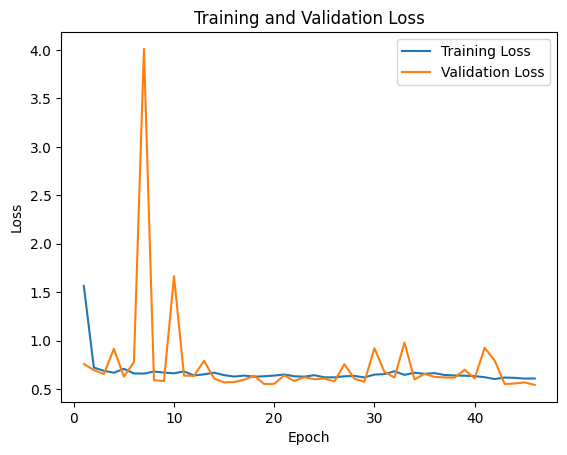

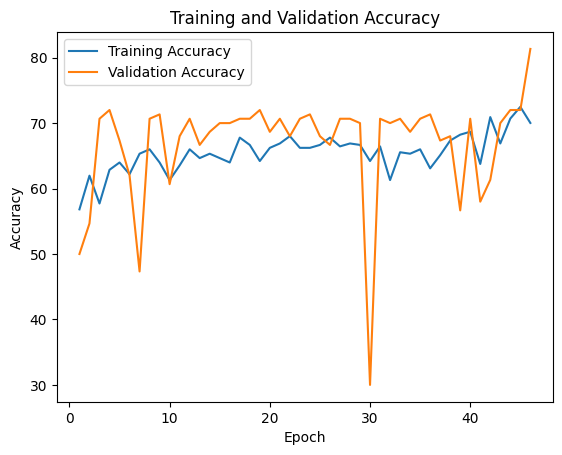

In [ ]:
max_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(max_val_accuracy) + 1
min_val_loss = val_losses[val_accuracies.index(max_val_accuracy)]
print(f"Highest Accuracy: {max_val_accuracy:.2f}% at Epoch {best_epoch}, Loss: {min_val_loss:.4f}")
print(', '.join(f"{loss:.4f}" for loss in val_losses))
print(', '.join(f"{accuracy:.2f}" for accuracy in val_accuracies))
if hasattr(model, "log_norms") and model.log_norms:
    print(', '.join(f"{norms:.4f}" for norms in train_base_norms))
    print(', '.join(f"{norms:.4f}" for norms in train_residual_norms))
    print(', '.join(f"{norms:.4f}" for norms in train_combined_norms))

window_size = 1
smooth_train_losses = moving_average(train_losses[:best_epoch], window_size)
smooth_val_losses = moving_average(val_losses[:best_epoch], window_size)
smooth_train_accuracies = moving_average(train_accuracies[:best_epoch], window_size)
smooth_val_accuracies = moving_average(val_accuracies[:best_epoch], window_size)
x_smooth = np.arange(window_size, best_epoch + 1)


plt.plot(x_smooth, smooth_train_losses, label = "Training Loss")
plt.plot(x_smooth, smooth_val_losses, label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(x_smooth, smooth_train_accuracies, label = "Training Accuracy")
plt.plot(x_smooth, smooth_val_accuracies, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-38-a7963087611e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Accuracy: 80.60%
Total test data: 67
Accurately predicted data: 54
Wrongly predicted data: 13

Classification Report:
              precision    recall  f1-score   support

   Parkinson       0.84      0.89      0.87        47
     Healthy       0.71      0.60      0.65        20

    accuracy                           0.81        67
   macro avg       0.77      0.75      0.76        67
weighted avg       0.80      0.81      0.80        67

Confusion Matrix:
[[42  5]
 [ 8 12]]


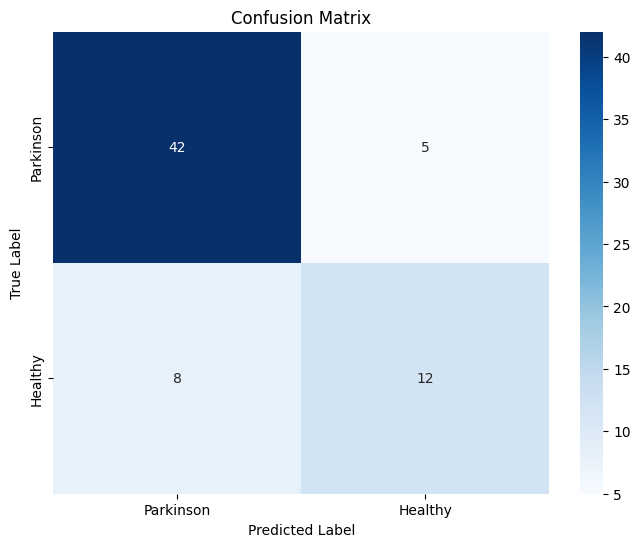

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test():
    model.eval()  # Set the model to evaluation mode
    correct = total = 0
    accurate = 0  # Number of correctly predicted samples
    all_targets = []
    all_preds = []

    with torch.no_grad():  # No gradients needed for testing
        for inputs, targets in test_loader:  # Assuming you have a test_loader for the test set
            inputs, targets = inputs.to(device), targets.to(device)

            with autocast():
                outputs = model(inputs)

            # Get predicted labels
            _, predicted = outputs.max(1)
            total += targets.size(0)
            accurate += predicted.eq(targets).sum().item()

            # Collect all the targets and predictions for confusion matrix
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = 100. * accurate / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Print additional statistics
    print(f'Total test data: {total}')
    print(f'Accurately predicted data: {accurate}')
    print(f'Wrongly predicted data: {total - accurate}')

    # Print out the classification report (precision, recall, f1-score, support)
    class_names = ['Parkinson', 'Healthy']  # Assuming you have two classes 0 - Parkinson, 1 - Healthy
    print('\nClassification Report:')
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    print('Confusion Matrix:')
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, cm, accurate, total, cm

# After training is complete, call the test function:
test_accuracy, confusion_matrix_result, accurate, total, cm = test()